In [1]:
import matplotlib.pyplot as plt
from read_cifar import load_cifar
from PIL import Image

In [2]:
i = 0


In [3]:
train, test = load_cifar()
img = train['data'][i]
# plt.imshow(img)
pil_image = Image.fromarray(img)
pil_image.save(f"images/train-{i}.png")
train['labels'][i]
i += 1

In [4]:
j = 0

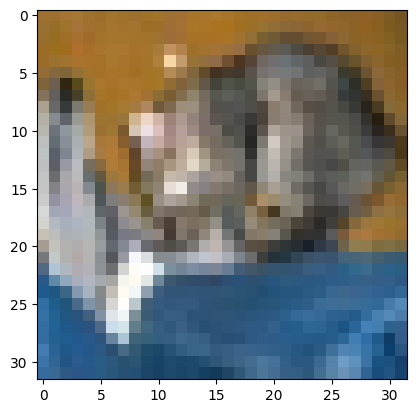

In [5]:
img = test['data'][j]
plt.imshow(img)

# 1. Is it a vehicle?

In [6]:
RANDOM_SEED = 64820101

In [7]:
from sklearn.svm import SVC
from svm_is_vehicle import load_cifar_is_vehicle
from svm_is_vehicle import preprocess_cifar_for_svc
from svm_is_vehicle import split_cifar_data_and_labels
from svm_is_vehicle import stratified_subset
from svm_is_vehicle import get_proportions_per_class
from svm_is_vehicle import evaluate_classifier_accuracy

In [8]:
train_data, test_data = load_cifar_is_vehicle()
print(f"{train_data['data'].shape = }")
print(f"{train_data['labels'].shape = }")

train_data['data'].shape = (50000, 32, 32, 3)
train_data['labels'].shape = (50000,)


In [9]:
train_data_svc = preprocess_cifar_for_svc(train_data)
print(f"{train_data_svc['data'].shape = }")
print(f"{train_data_svc['labels'].shape = }")

train_data_svc['data'].shape = (50000, 3072)
train_data_svc['labels'].shape = (50000,)


In [10]:
test_data_svc = preprocess_cifar_for_svc(test_data)
print(f"{test_data_svc['data'].shape = }")
print(f"{test_data_svc['labels'].shape = }")

test_data_svc['data'].shape = (10000, 3072)
test_data_svc['labels'].shape = (10000,)


In [11]:
X_train, y_train = split_cifar_data_and_labels(train_data_svc)
X_test, y_test = split_cifar_data_and_labels(test_data_svc)

In [12]:
X_train_subset, y_train_subset = stratified_subset(X_train, y_train, subset_size=1000, random_seed=RANDOM_SEED)

In [13]:
get_proportions_per_class(y_train_subset)

{np.int64(0): np.float64(0.6), np.int64(1): np.float64(0.4)}

## Linear Kernel SVC

### C=1

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [39]:
svc_vehicle = SVC(kernel="linear", verbose=True)
svc_vehicle = svc_vehicle.fit(X_train_subset, y_train_subset)
predictions = svc_vehicle.predict(X_test)
accuracy = evaluate_classifier_accuracy(y_test, predictions)
print(f"{accuracy = }")


[LibSVM]............................................*.....................*...*
optimization finished, #iter = 67717
obj = -0.000996, rho = -1.325983
nSV = 494, nBSV = 0
Total nSV = 494
accuracy = 0.7187


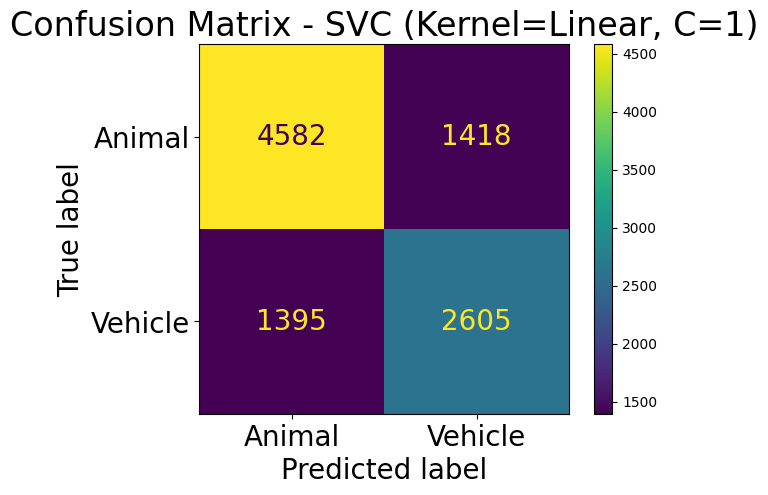

In [40]:
fig, ax = plt.subplots()
conf_mat_disp = ConfusionMatrixDisplay.from_predictions(
    y_test, predictions, display_labels=["Animal", "Vehicle"], ax=ax, text_kw={"fontsize": 20}
)
_ = ax.set_title("Confusion Matrix - SVC (Kernel=Linear, C=1)", fontsize=24)
_ = ax.tick_params(labelsize=20)
_ = ax.set_xlabel(ax.get_xlabel(), fontsize=20)
_ = ax.set_ylabel(ax.get_ylabel(), fontsize=20)

### Cross-validation grid search for C and gamma

In [16]:
from svm_is_vehicle import cross_validation
import numpy as np

In [17]:
def cv_train_and_evaluate_svc(
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        svc_kernel: str,
        folds: int,
        param_grid: dict[str, list],
) -> SVC:
    model = SVC(kernel=svc_kernel)
    clf = cross_validation(X_train, y_train, param_grid, folds, model)
    print(f"Found best parameters:\n{clf.best_params_}")
    cv_best_model = SVC(C=clf.best_estimator_.C, kernel=svc_kernel)
    cv_best_model.fit(X_train, y_train)
    predictions = cv_best_model.predict(X_test)
    accuracy = evaluate_classifier_accuracy(y_test, predictions)
    print(f"{accuracy = }")
    fig, ax = plt.subplots()
    _ = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Animal", "Vehicle"], ax=ax, text_kw={"fontsize": 20}
    )
    _ = ax.set_title(f"Confusion Matrix - SVC (Kernel={svc_kernel}, C={clf.best_params_['C']})", fontsize=24)
    _ = ax.tick_params(labelsize=20)
    _ = ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    _ = ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    plt.show()
    return model

### Linear

Found best parameters:
{'C': 1}
accuracy = 0.7187


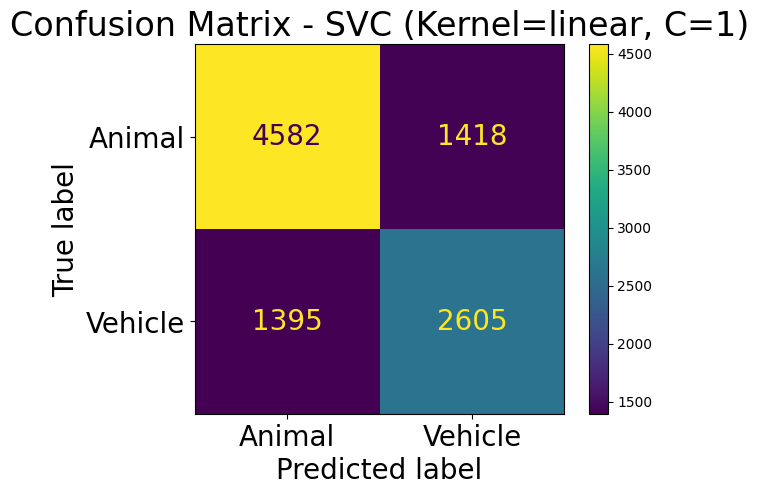

In [43]:
folds = 5
param_grid = {"C": [1, 10, 100]}
linear_svc = cv_train_and_evaluate_svc(
    X_train_subset,
    y_train_subset,
    X_test,
    y_test,
    "linear",
    folds,
    param_grid,
)

### RBF

Found best parameters:
{'C': 10}
accuracy = 0.8179


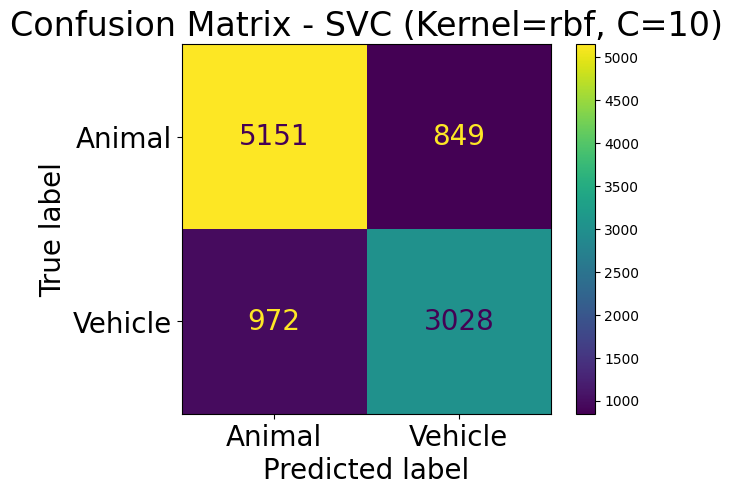

In [44]:
folds = 5
param_grid = {"C": [1, 10, 100]}
rbf_svc = cv_train_and_evaluate_svc(
    X_train_subset,
    y_train_subset,
    X_test,
    y_test,
    "rbf",
    folds,
    param_grid,
)

# 2. SVM with PCA

In [18]:
from pca import compute_PCA
from sklearn.svm import LinearSVC

In [19]:
def train_and_evaluate_svc(
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        C: float,
        svc_kernel: str
):
    model = LinearSVC(C=C) if svc_kernel == "linear" else SVC(C=C, kernel=svc_kernel)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = evaluate_classifier_accuracy(y_test, predictions)
    return model, accuracy


def cv_train_and_evaluate_svc_with_pca(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    svc_kernel: str,
    folds: int,
    param_grid: dict[str, list],
) -> SVC:
    model = LinearSVC() if svc_kernel == "linear" else SVC(kernel=svc_kernel)
    clf = cross_validation(X_train, y_train, param_grid, folds, model)
    print(f"Found best parameters:\n{clf.best_params_}")
    cv_best_model = LinearSVC(C=clf.best_estimator_.C) if svc_kernel == "linear" else SVC(C=clf.best_estimator_.C, kernel=svc_kernel)
    cv_best_model.fit(X_train, y_train)
    predictions = cv_best_model.predict(X_test)
    accuracy = evaluate_classifier_accuracy(y_test, predictions)
    print(f"{accuracy = }")
    fig, ax = plt.subplots()
    _ = ConfusionMatrixDisplay.from_predictions(
        y_test,
        predictions,
        display_labels=["Animal", "Vehicle"],
        ax=ax,
        text_kw={"fontsize": 20},
    )
    _ = ax.set_title(
        f"Confusion Matrix - SVC w/ PCA (Kernel={svc_kernel}, C={clf.best_params_['C']})",
        fontsize=24,
    )
    _ = ax.tick_params(labelsize=20)
    _ = ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    _ = ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    plt.show()
    return model

In [20]:
min_components, max_components = 5, 300
pca_model = compute_PCA(X_train_subset, max_components)
X_train_subset_pca = pca_model.transform(X_train_subset)
X_test_pca = pca_model.transform(X_test)

### Linear Kernel

In [48]:
n_components_array = np.arange(min_components, max_components, step=5)
accuracy_dict = dict()
for n_components in n_components_array:
    X_train_pca_cropped = X_train_subset_pca[:, :n_components]
    X_test_pca_cropped = X_test_pca[:, :n_components]
    model, accuracy = train_and_evaluate_svc(
        X_train_pca_cropped,
        y_train_subset,
        X_test_pca_cropped,
        y_test,
        1,
        "linear"
    )
    accuracy_dict[n_components] = accuracy

In [49]:
best_num_components = int(max(accuracy_dict, key=accuracy_dict.get))
print(f"{best_num_components = }")

best_num_components = 95


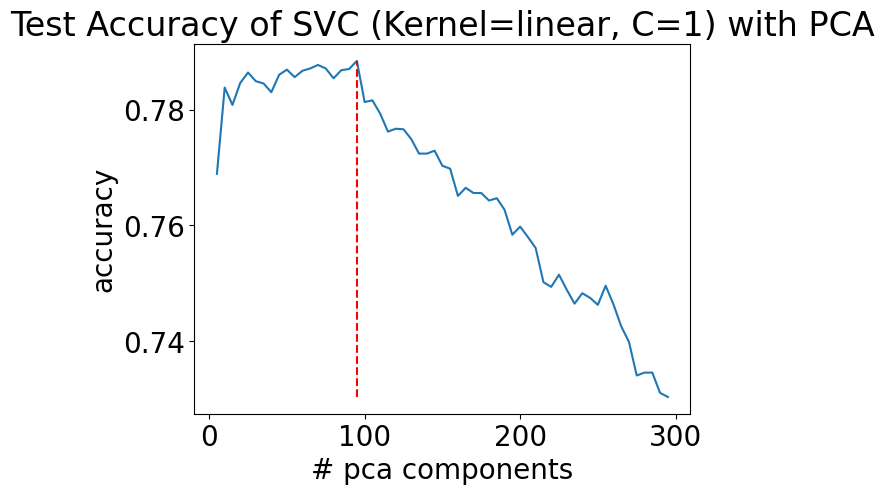

In [50]:
plt.plot(accuracy_dict.keys(), accuracy_dict.values())
plt.vlines(best_num_components, min(accuracy_dict.values()), accuracy_dict[best_num_components], colors=["red"], linestyles="dashed")
plt.title("Test Accuracy of SVC (Kernel=linear, C=1) with PCA", fontsize=24)
plt.tick_params(labelsize=20)
plt.xlabel("# pca components", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.show()

In [51]:
X_test_pca[:, :best_num_components].shape

(10000, 95)

Found best parameters:
{'C': 1}
accuracy = 0.7883


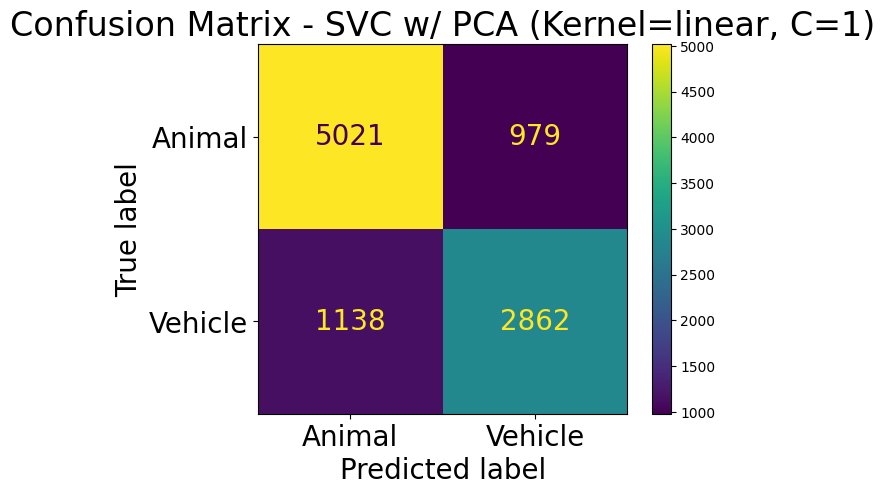

In [ ]:
folds = 5
param_grid = {"C": [1, 10, 100]}
rbf_svc = cv_train_and_evaluate_svc_with_pca(
    X_train_subset_pca[:, :best_num_components],
    y_train_subset,
    X_test_pca[:, :best_num_components],
    y_test,
    "linear",
    folds,
    param_grid,
)

### RBF Kernel

In [53]:
n_components_array = np.arange(min_components, max_components, step=5)
accuracy_dict = dict()
for n_components in n_components_array:
    X_train_pca_cropped = X_train_subset_pca[:, :n_components]
    X_test_pca_cropped = X_test_pca[:, :n_components]
    model, accuracy = train_and_evaluate_svc(
        X_train_pca_cropped,
        y_train_subset,
        X_test_pca_cropped,
        y_test,
        10,
        "rbf"
    )
    accuracy_dict[n_components] = accuracy

In [54]:
best_num_components = int(max(accuracy_dict, key=accuracy_dict.get))
print(f"{best_num_components = }")

best_num_components = 80


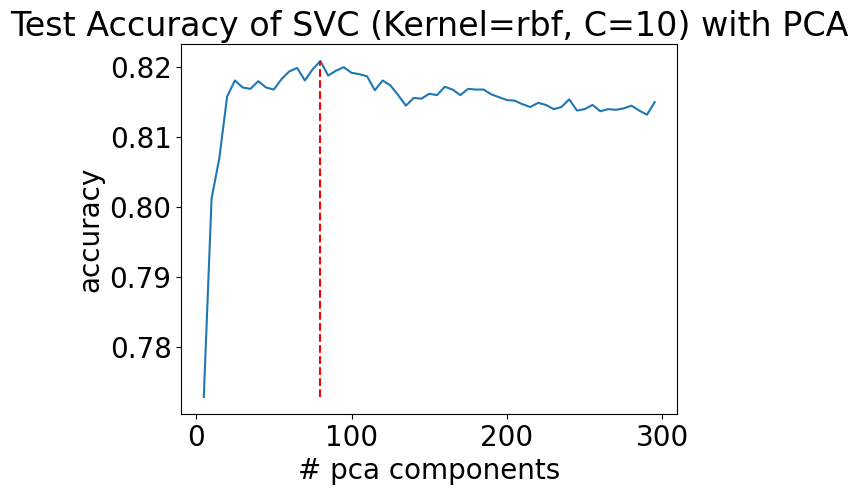

In [55]:
plt.plot(accuracy_dict.keys(), accuracy_dict.values())
plt.vlines(best_num_components, min(accuracy_dict.values()), accuracy_dict[best_num_components], colors=["red"], linestyles="dashed")
plt.title("Test Accuracy of SVC (Kernel=rbf, C=10) with PCA", fontsize=24)
plt.tick_params(labelsize=20)
plt.xlabel("# pca components", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.show()

In [56]:
X_test_pca[:, :best_num_components].shape

(10000, 80)

Found best parameters:
{'C': 10}
accuracy = 0.8209


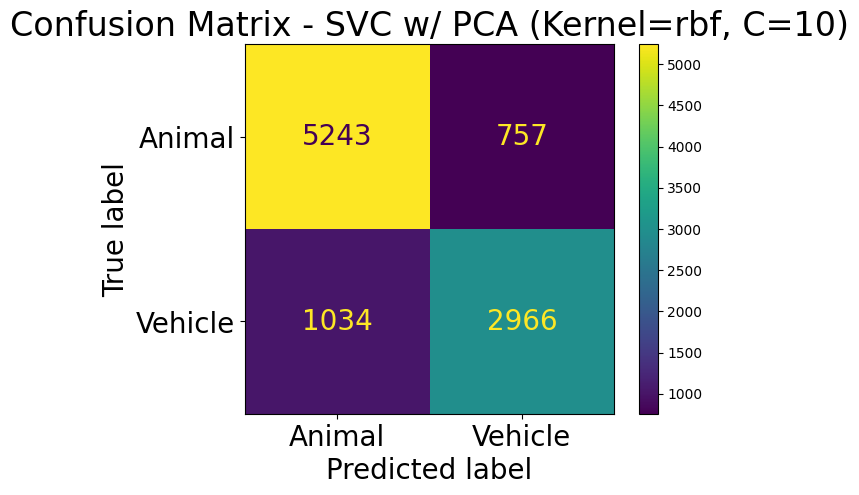

In [57]:
folds = 5
param_grid = {"C": [1, 10, 100]}
rbf_svc = cv_train_and_evaluate_svc_with_pca(
    X_train_subset_pca[:, :best_num_components],
    y_train_subset,
    X_test_pca[:, :best_num_components],
    y_test,
    "rbf",
    folds,
    param_grid,
)

## Multi-classification Task (Animals Only)

Remember to explain what OneVsRestClassifier does in the presentation

In [58]:
import numpy as np
from read_cifar import load_cifar
from svm_is_vehicle import split_cifar_data_and_labels
from typing import Literal
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


RANDOM_SEED = 42021


def transform_cifar_dataset_to_is_animal(dataset: dict[np.ndarray, np.ndarray]):
    data, labels = split_cifar_data_and_labels(dataset)
    vehicle_classes = np.array([0, 1, 8, 9])
    is_animal = ~np.isin(labels, vehicle_classes)
    data = data[is_animal]
    labels = labels[is_animal] - 2
    return {'data': data, 'labels': labels}


def stratified_subset(
    dataset: dict, proportion: float, random_state: int = None
) -> dict:
    """
    Returns a stratified subset of the dataset based on labels.

    Args:
        dataset (dict): Dictionary with keys 'data' (np.array) and 'labels' (np.array).
        proportion (float): Proportion of the dataset to include in the subset (0 < proportion <= 1).
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        dict: Subset of the dataset with 'data' and 'labels' keys, stratified by labels.
    """

    assert 0 < proportion <= 1, "Proportion must be between 0 and 1."
    assert (
        "data" in dataset and "labels" in dataset
    ), "Dataset must contain 'data' and 'labels' keys."
    assert len(dataset["data"]) == len(
        dataset["labels"]
    ), "Data and labels must be the same length."

    # Stratified sampling using train_test_split
    data = dataset["data"]
    labels = dataset["labels"]

    _, subset_data, _, subset_labels = train_test_split(
        data, labels, test_size=proportion, stratify=labels, random_state=random_state
    )
    return {"data": subset_data, "labels": subset_labels}


train_set, test_set = load_cifar()
train_set["data"] = train_set["data"].reshape(train_set["data"].shape[0], -1)
test_set["data"] = test_set["data"].reshape(test_set["data"].shape[0], -1)

animal_train_set = transform_cifar_dataset_to_is_animal(train_set)
animal_test_set = transform_cifar_dataset_to_is_animal(test_set)
animal_train_subset = stratified_subset(animal_train_set, proportion=0.01, random_state=RANDOM_SEED)
animal_train_subset_data, animal_train_subset_labels = split_cifar_data_and_labels(animal_train_subset)

### OneVsRest Linear SVC

In [59]:
def run_animals_experiment(
    kernel: str,
    C: float,
    multiclass_method: Literal["OneVsOneClassifier", "OneVsRestClassifier"],
):
    svc = SVC(kernel=kernel, C=C)
    svc_multi = None
    if multiclass_method == "OneVsOneClassifier":
        svc_multi = OneVsOneClassifier(svc)
    elif multiclass_method == "OneVsRestClassifier":
        svc_multi = OneVsRestClassifier(svc)
    else:
        raise ValueError("invalid value for multiclass_method")
    print(f"training SVC ({kernel=} {C=} {multiclass_method=})...")
    svc_multi = svc_multi.fit(animal_train_subset_data, animal_train_subset_labels)
    print("testing SVC...")
    y_pred = svc_multi.predict(animal_test_set["data"])
    accuracy = accuracy_score(animal_test_set["labels"], y_pred)
    print(f"{accuracy = }")
    _ = ConfusionMatrixDisplay.from_predictions(animal_test_set["labels"], y_pred)
    plt.plot()

training SVC (kernel='linear' C=1 multiclass_method='OneVsRestClassifier')...
testing SVC...
accuracy = 0.2595


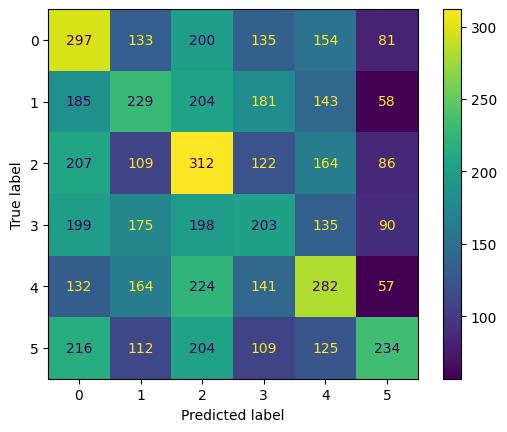

In [60]:
run_animals_experiment("linear", C=1, multiclass_method="OneVsRestClassifier")

training SVC (kernel='rbf' C=1 multiclass_method='OneVsRestClassifier')...
testing SVC...
accuracy = 0.34833333333333333


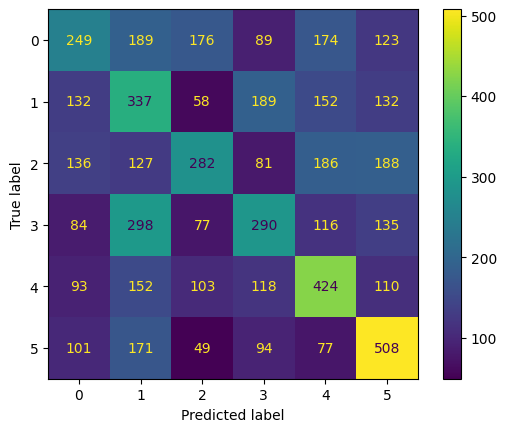

In [61]:
run_animals_experiment("rbf", C=1, multiclass_method="OneVsRestClassifier")


training SVC (kernel='rbf' C=10 multiclass_method='OneVsRestClassifier')...
testing SVC...
accuracy = 0.3365


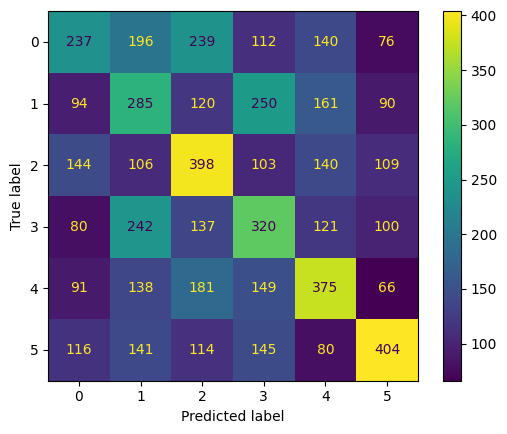

In [62]:
run_animals_experiment("rbf", C=10, multiclass_method="OneVsRestClassifier")


training SVC (kernel='rbf' C=100 multiclass_method='OneVsRestClassifier')...
testing SVC...
accuracy = 0.3408333333333333


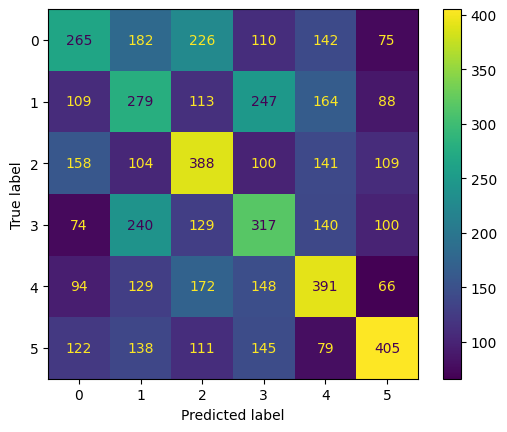

In [63]:
run_animals_experiment("rbf", C=100, multiclass_method="OneVsRestClassifier")

### OneVsOne RBF SVC

training SVC (kernel='linear' C=1 multiclass_method='OneVsOneClassifier')...
testing SVC...
accuracy = 0.28983333333333333


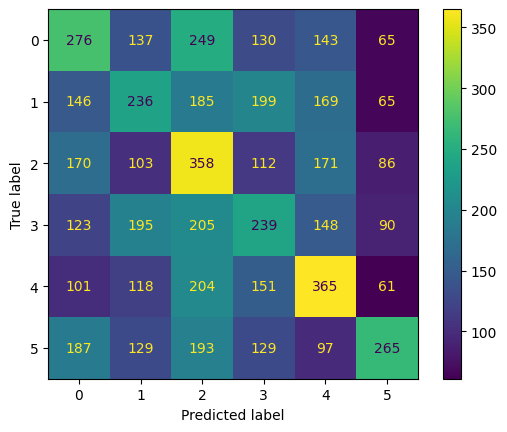

In [64]:
run_animals_experiment("linear", C=1, multiclass_method="OneVsOneClassifier")


training SVC (kernel='rbf' C=1 multiclass_method='OneVsOneClassifier')...
testing SVC...
accuracy = 0.332


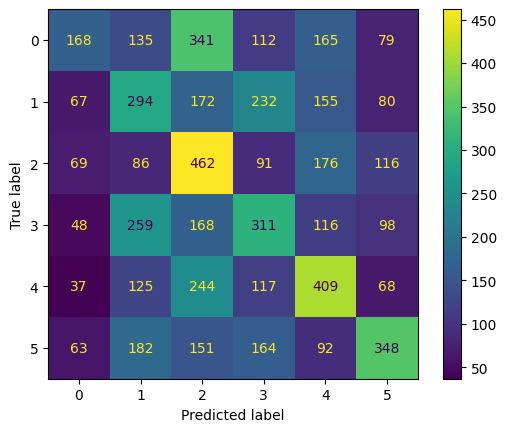

In [65]:
run_animals_experiment("rbf", C=1, multiclass_method="OneVsOneClassifier")


training SVC (kernel='rbf' C=10 multiclass_method='OneVsOneClassifier')...
testing SVC...
accuracy = 0.3373333333333333


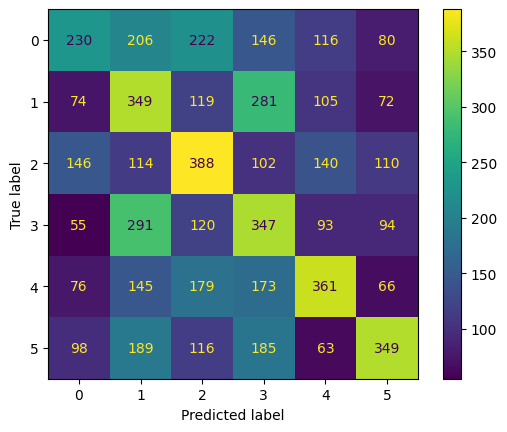

In [66]:
run_animals_experiment("rbf", C=10, multiclass_method="OneVsOneClassifier")


training SVC (kernel='rbf' C=100 multiclass_method='OneVsOneClassifier')...
testing SVC...
accuracy = 0.3363333333333333


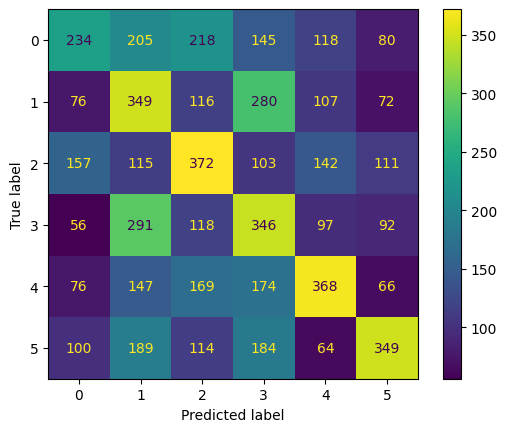

In [67]:
run_animals_experiment("rbf", C=100, multiclass_method="OneVsOneClassifier")

## Full Classification

In [20]:
import numpy as np
from read_cifar import load_cifar
from svm_is_vehicle import split_cifar_data_and_labels
from typing import Literal
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


RANDOM_SEED = 420674

def stratified_subset(
    dataset: dict, proportion: float, random_state: int = None
) -> dict:
    """
    Returns a stratified subset of the dataset based on labels.

    Args:
        dataset (dict): Dictionary with keys 'data' (np.array) and 'labels' (np.array).
        proportion (float): Proportion of the dataset to include in the subset (0 < proportion <= 1).
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        dict: Subset of the dataset with 'data' and 'labels' keys, stratified by labels.
    """

    assert 0 < proportion <= 1, "Proportion must be between 0 and 1."
    assert (
        "data" in dataset and "labels" in dataset
    ), "Dataset must contain 'data' and 'labels' keys."
    assert len(dataset["data"]) == len(
        dataset["labels"]
    ), "Data and labels must be the same length."

    # Stratified sampling using train_test_split
    data = dataset["data"]
    labels = dataset["labels"]

    _, subset_data, _, subset_labels = train_test_split(
        data, labels, test_size=proportion, stratify=labels, random_state=random_state
    )
    return {"data": subset_data, "labels": subset_labels}


train_set, test_set = load_cifar()
train_set["data"] = train_set["data"].reshape(train_set["data"].shape[0], -1)
test_set["data"] = test_set["data"].reshape(test_set["data"].shape[0], -1)

train_subset = stratified_subset(
    train_set, proportion=0.01, random_state=RANDOM_SEED
)
train_subset_data, train_subset_labels = split_cifar_data_and_labels(
    train_subset
)

In [40]:
def run_full_experiment(
    kernel: str,
    C: float,
    multiclass_method: Literal["OneVsOneClassifier", "OneVsRestClassifier"],
):
    svc = LinearSVC(C=C) if kernel == "linear" else SVC(kernel=kernel, C=C)
    svc_multi = None
    if multiclass_method == "OneVsOneClassifier":
        svc_multi = OneVsOneClassifier(svc)
    elif multiclass_method == "OneVsRestClassifier":
        svc_multi = OneVsRestClassifier(svc)
    else:
        raise ValueError("invalid value for multiclass_method")
    print(f"training SVC ({kernel=} {C=} {multiclass_method=})...")
    svc_multi = svc_multi.fit(train_subset_data, train_subset_labels)
    print("testing SVC...")
    y_pred = svc_multi.predict(test_set["data"])
    accuracy = accuracy_score(test_set["labels"], y_pred)
    print(f"{accuracy = }")
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    _ = ConfusionMatrixDisplay.from_predictions(
        test_set["labels"],
        y_pred,
        display_labels=["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"],
        xticks_rotation="vertical",
        ax=ax,
        text_kw={"fontsize": 20},
    )
    _ = ax.set_title(
        f"{multiclass_method} SVC (Kernel={kernel}, {C=})",
        fontsize=24,
    )
    _ = ax.tick_params(labelsize=20)
    _ = ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    _ = ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    plt.show()

training SVC (kernel='linear' C=1 multiclass_method='OneVsRestClassifier')...


/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear fa

testing SVC...
accuracy = 0.2274


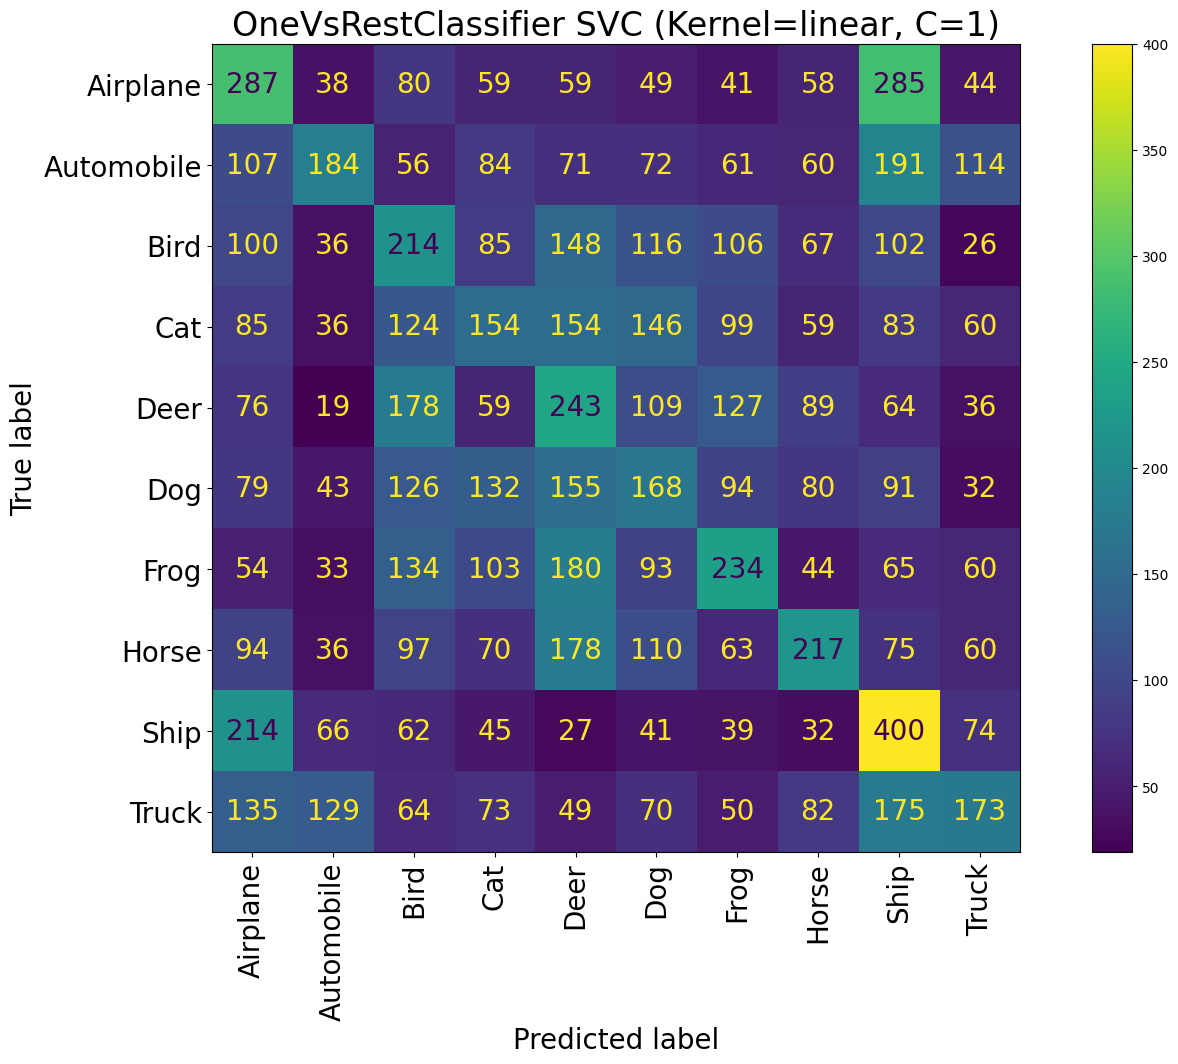

In [41]:
run_full_experiment("linear", C=1, multiclass_method="OneVsRestClassifier")

training SVC (kernel='linear' C=1 multiclass_method='OneVsOneClassifier')...


/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/will/Documents/University/Lab ML Algorithms/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear fa

testing SVC...
accuracy = 0.263


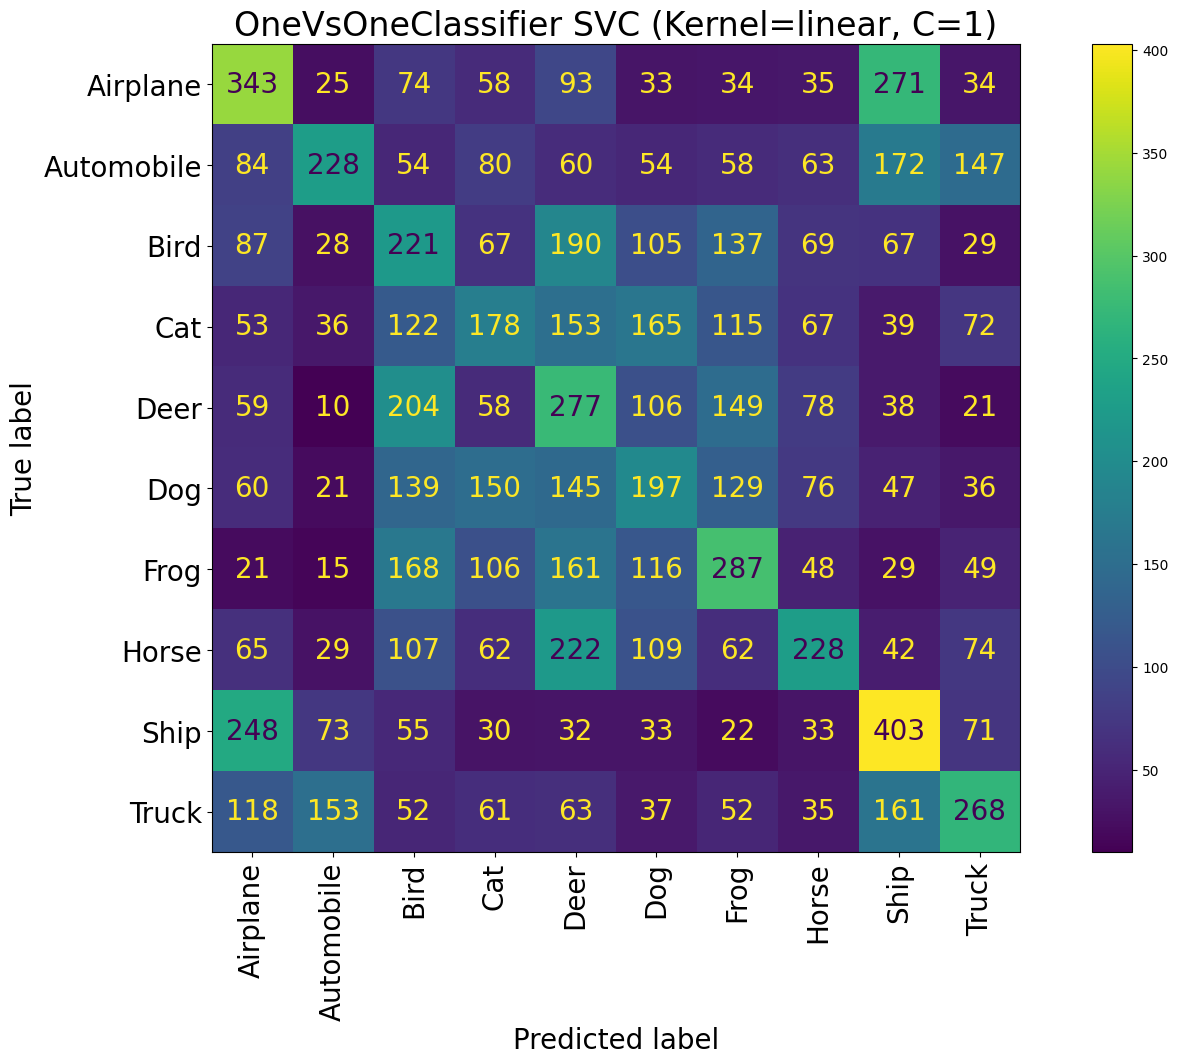

In [42]:
run_full_experiment("linear", C=1, multiclass_method="OneVsOneClassifier")

training SVC (kernel='rbf' C=10 multiclass_method='OneVsRestClassifier')...
testing SVC...
accuracy = 0.3293


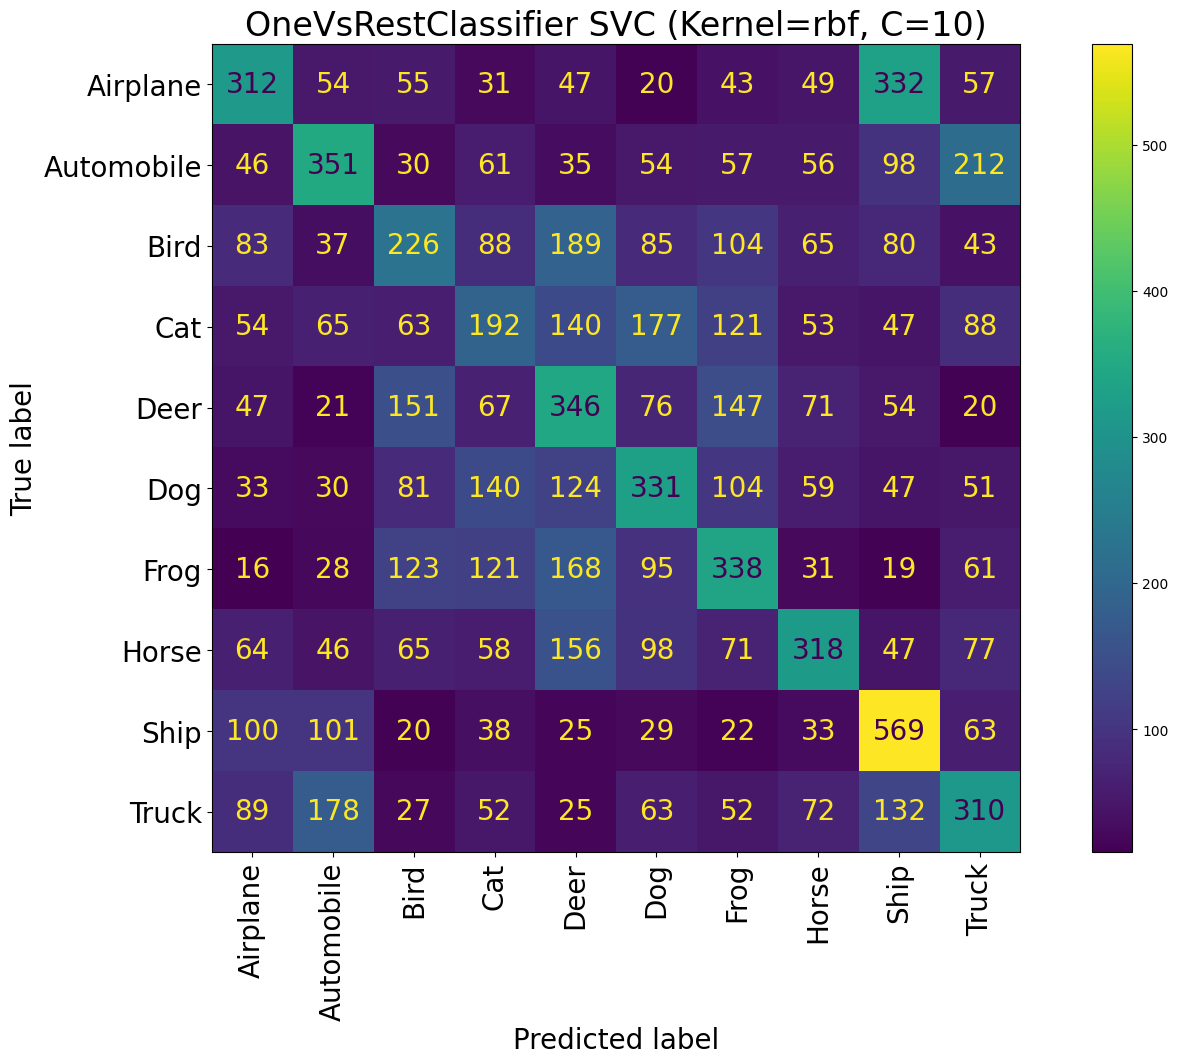

In [43]:
run_full_experiment("rbf", C=10, multiclass_method="OneVsRestClassifier")

training SVC (kernel='rbf' C=10 multiclass_method='OneVsOneClassifier')...


testing SVC...
accuracy = 0.3335


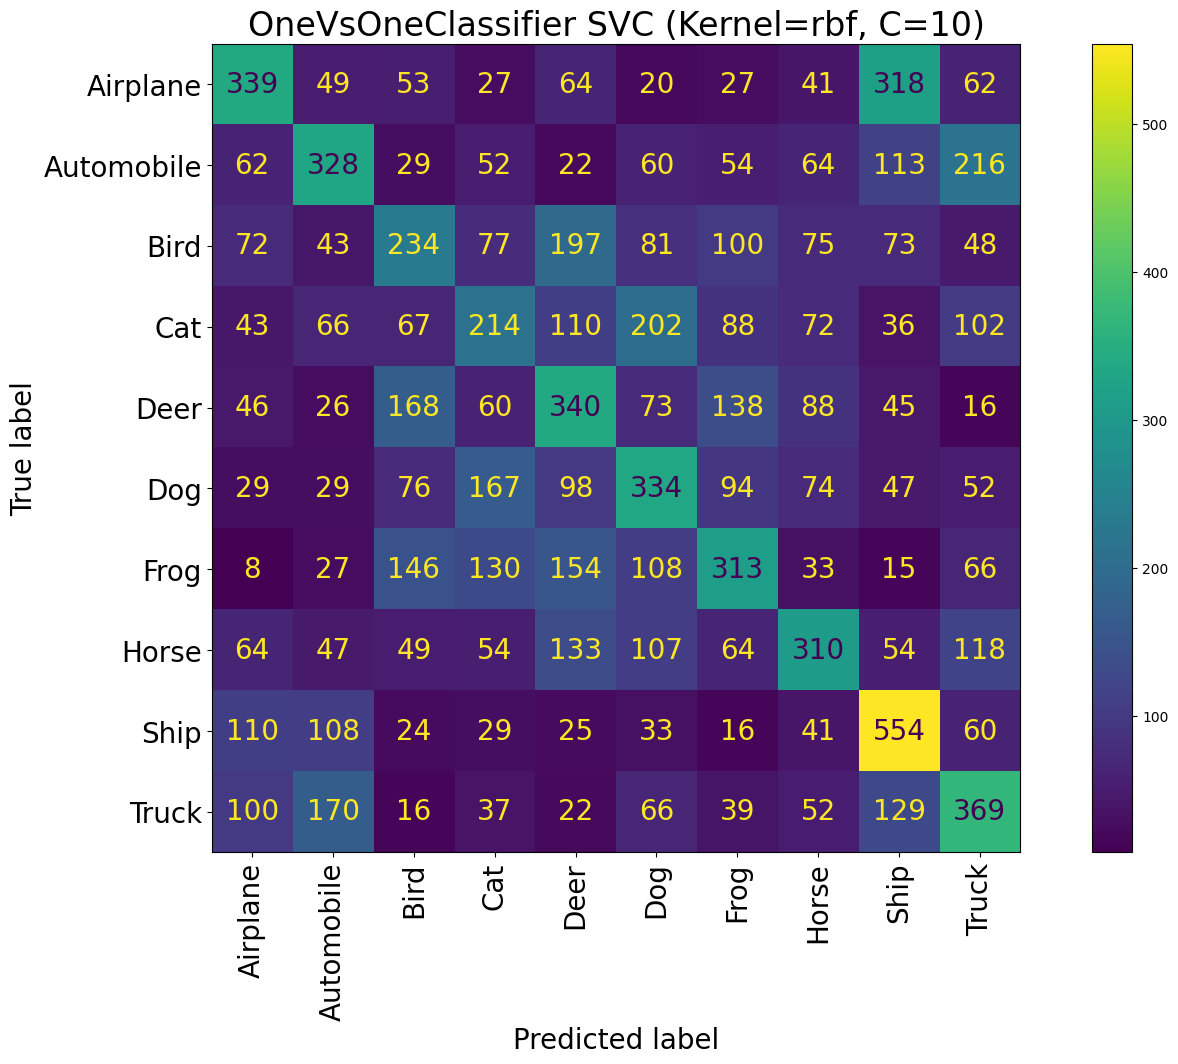

In [44]:
run_full_experiment("rbf", C=10, multiclass_method="OneVsOneClassifier")

In [83]:
from pca import compute_PCA

def run_full_experiment_pca(
    kernel: str,
    C: float,
    multiclass_method: Literal["OneVsOneClassifier", "OneVsRestClassifier"],
    pc: int,
):
    svc = LinearSVC(C=C) if kernel == "linear" else SVC(kernel=kernel, C=C)
    svc_multi = None
    if multiclass_method == "OneVsOneClassifier":
        svc_multi = OneVsOneClassifier(svc)
    elif multiclass_method == "OneVsRestClassifier":
        svc_multi = OneVsRestClassifier(svc)
    else:
        raise ValueError("invalid value for multiclass_method")

    pca_model = compute_PCA(train_subset_data, pc)
    train_subset_data_pca = pca_model.transform(train_subset_data)
    test_data_pca = pca_model.transform(test_set["data"])

    print(f"training SVC ({kernel=} {C=} {multiclass_method=})...")
    svc_multi = svc_multi.fit(train_subset_data_pca, train_subset_labels)
    print("testing SVC...")
    y_pred = svc_multi.predict(test_data_pca)
    accuracy = accuracy_score(test_set["labels"], y_pred)
    print(f"{accuracy = }")
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    _ = ConfusionMatrixDisplay.from_predictions(
        test_set["labels"],
        y_pred,
        display_labels=[
            "Airplane",
            "Automobile",
            "Bird",
            "Cat",
            "Deer",
            "Dog",
            "Frog",
            "Horse",
            "Ship",
            "Truck",
        ],
        xticks_rotation="vertical",
        ax=ax,
        text_kw={"fontsize": 20},
    )
    _ = ax.set_title(
        f"{multiclass_method} SVC w/ PCA (Kernel={kernel}, {C=})",
        fontsize=24,
    )
    _ = ax.tick_params(labelsize=20)
    _ = ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    _ = ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    plt.show()

training SVC (kernel='rbf' C=10 multiclass_method='OneVsOneClassifier')...
testing SVC...
accuracy = 0.3258


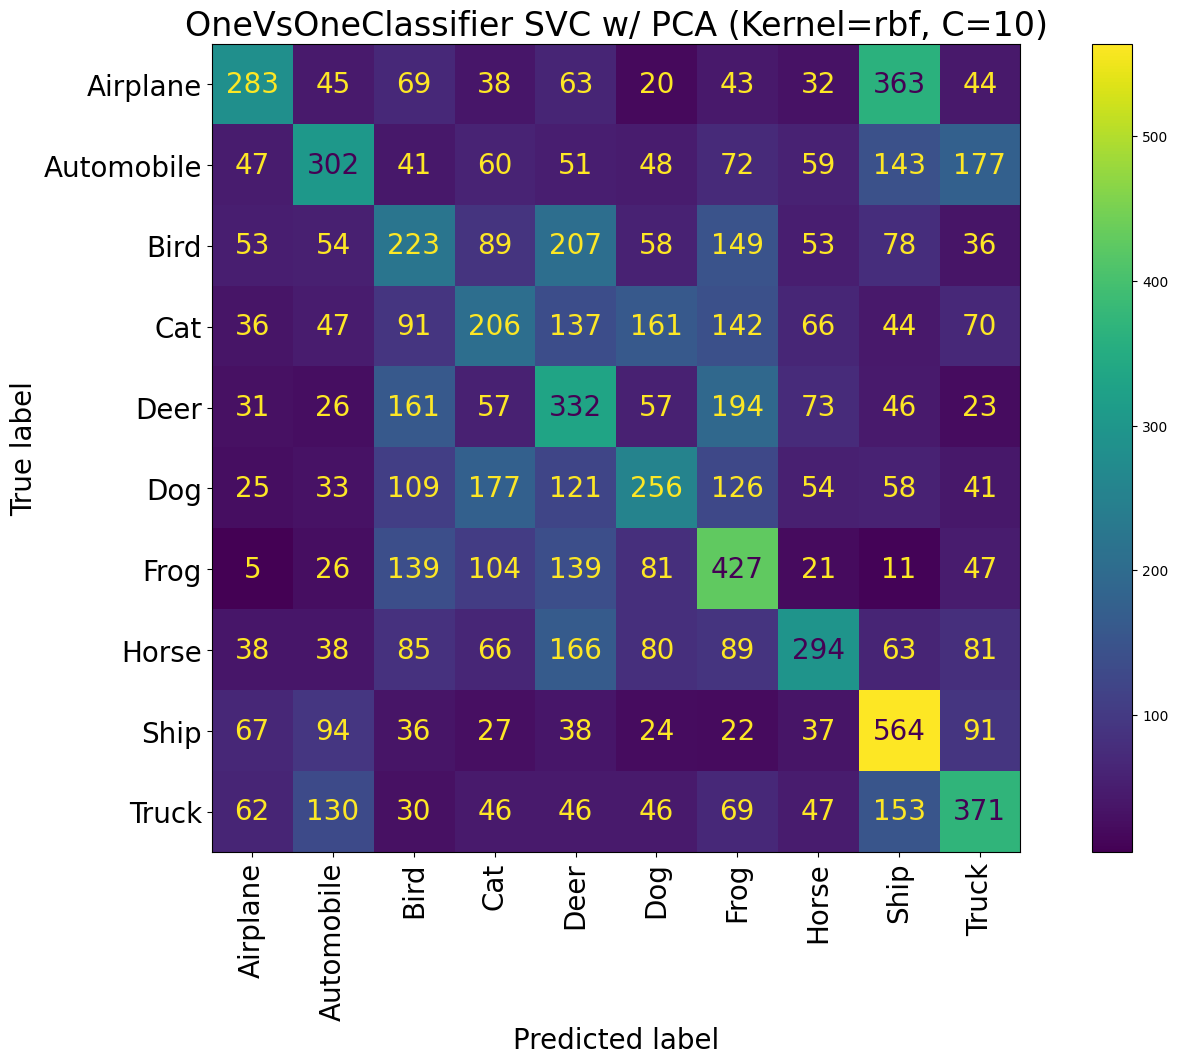

In [84]:
run_full_experiment_pca("rbf", 10, "OneVsOneClassifier", 80)